In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

import numpy as np
import pandas as pd

In [2]:
train_one = pd.read_csv("data/train3.csv")
test_one = pd.read_csv("data/test3.csv")
train_merge = pd.read_csv("data/train_merged.csv")
test_merge = pd.read_csv("data/test_merged.csv")

In [3]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [4]:
train_merge['등록차량수'] = train['등록차량수']

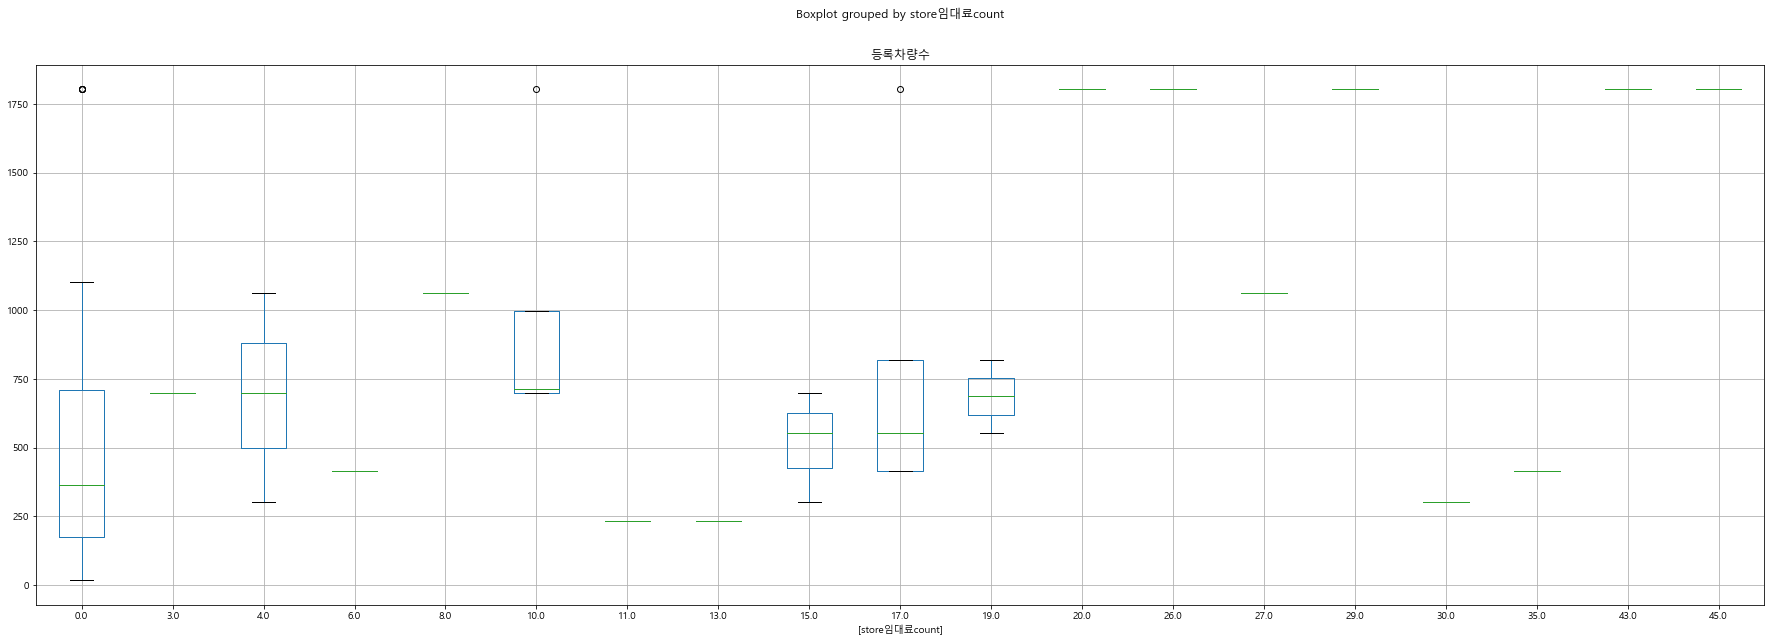

In [5]:
fig, ax = plt.subplots(figsize=(30,10))
train_merge.boxplot(column=['등록차량수'],by=['store임대료count'],ax=ax)

- 0
- 1~10
- 11~19
- 20이상

In [6]:
tmp = train_merge.copy()
tmp.loc[tmp['store임대료count'].isin(range(1,11)),'store임대료count'] = 1
tmp.loc[tmp['store임대료count'].isin(range(11,20)),'store임대료count'] = 2
tmp.loc[tmp['store임대료count'].isin(range(20,100)),'store임대료count'] = 3

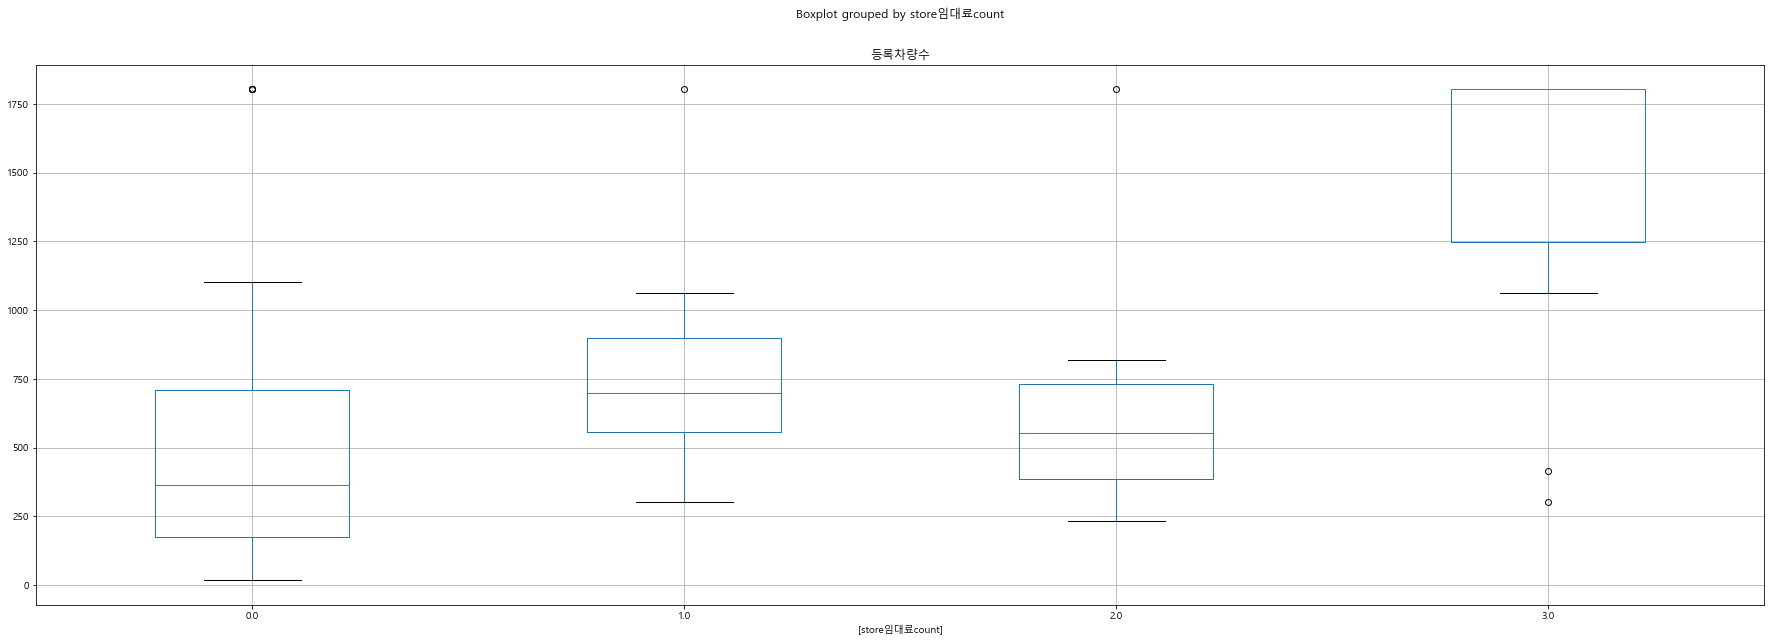

In [7]:
fig, ax = plt.subplots(figsize=(30,10))
tmp.boxplot(column=['등록차량수'],by=['store임대료count'],ax=ax)

In [8]:
d = ['store임대료min','store임대료25%','store임대료50%','store임대료75%','store임대보증금min','store임대보증금25%','store임대보증금50%','store임대보증금75%']
train_one = train_one.drop(d,axis=1)

train_one['store개수'] = tmp['store임대료count']
train_one['store개수'] = train_one['store개수'].apply(lambda x : str(x))
train_one = train_one.join(train_merge[['store임대료mean','store임대료std']])
train_one = train_one.join(train_merge[['store임대보증금mean','store임대보증금std']])

In [9]:
tmp = test_merge.copy()
tmp.loc[tmp['store임대료count'].isin(range(1,11)),'store임대료count'] = 1
tmp.loc[tmp['store임대료count'].isin(range(11,20)),'store임대료count'] = 2
tmp.loc[tmp['store임대료count'].isin(range(20,100)),'store임대료count'] = 3

In [10]:
d = ['store임대료min','store임대료25%','store임대료50%','store임대료75%','store임대보증금min','store임대보증금25%','store임대보증금50%','store임대보증금75%']
test_one = test_one.drop(d,axis=1)

test_one['store개수'] = tmp['store임대료count']
test_one['store개수'] = test_one['store개수'].apply(lambda x : str(x))
test_one = test_one.join(test_merge[['store임대료mean','store임대료std']])
test_one = test_one.join(test_merge[['store임대보증금mean','store임대보증금std']])

In [11]:
train_one = train_one.join(pd.get_dummies(train_one['store개수'],prefix='store_count')).iloc[:,:-1]
train_one = train_one.drop('store개수',axis=1)

In [12]:
test_one = test_one.join(pd.get_dummies(test_one['store개수'],prefix='store_count')).iloc[:,:-1]
test_one = test_one.drop('store개수',axis=1)
test_one['store_count_1.0'] = 0

In [13]:
def func3(x,dic):
    for i in dic.keys():
        if len(dic[i]) == len(x):
            if all(dic[i] == x):
                return i


train.loc[train['공급유형'].isin(['영구임대', '행복주택']),'공급유형'] = '영구/행복'
test.loc[test['공급유형'].isin(['영구임대', '행복주택']),'공급유형'] = '영구/행복'

train.loc[train['공급유형'].isin(['공공임대(10년)', '공공임대(5년)']),'공급유형'] = '공공임대(단기)'
test.loc[test['공급유형'].isin(['공공임대(10년)', '공공임대(5년)']),'공급유형'] = '공공임대(단기)'

no_shop = train[train['공급유형']!='임대상가']
uniq = np.reshape(no_shop['공급유형'].unique(),(7,1))

dic = dict(enumerate(uniq))
dic[8] = ['공공임대(단기)', '국민임대']
dic[9] = ['장기전세', '국민임대', '영구/행복']
dic[10] = ['국민임대', '영구/행복']
dic[11] = ['공공임대(단기)', '공공임대(분납)']
dic[12] = ['공공분양', '공공임대(단기)', '공공임대(분납)']
dic[13] = ['공공임대(50년)', '영구/행복']
dic[14] = ['장기전세', '공공임대(단기)', '공공임대(분납)']

dic1 = dict()
for i in dic.keys():
    val = train.loc[train['공급유형'].isin(dic[i]),'임대보증금'].mean()
    dic1[i] = val


no_shop = train[train['공급유형']!='임대상가']
sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
sample['cluster'] = sample['cluster'].apply(lambda x: int(x))
train = pd.merge(train,sample[['단지코드','cluster']],on='단지코드',how='left')
train['cluster_임대보증금'] = train['cluster'].apply(lambda x: dic1[x])
train = train.drop(['공급유형'],axis=1)


no_shop = test[test['공급유형']!='임대상가']
sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
test = pd.merge(test,sample[['단지코드','cluster']],on='단지코드',how='left')
test['cluster_임대보증금'] = test['cluster'].apply(lambda x: dic1[x])
test = test.drop(['공급유형'],axis=1)

In [14]:
tmp = train[['단지코드','cluster_임대보증금']].drop_duplicates().reset_index(drop=True)
train_one['cluster_임대보증금'] = tmp['cluster_임대보증금']

In [15]:
tmp = test[['단지코드','cluster_임대보증금']].drop_duplicates().reset_index(drop=True)
test_one['cluster_임대보증금'] = tmp['cluster_임대보증금']

In [16]:
print(train_one.shape)
print(test_one.shape)

(414, 48)
(147, 47)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae

from catboost import CatBoostRegressor

In [19]:
X = train_one.drop(['등록차량수','단지코드'],axis=1)
y = train_one['등록차량수']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=2021,shuffle=True)


cb = CatBoostRegressor(random_state=2021,verbose=False,loss_function='MAE').fit(X_train, y_train)
pred = cb.predict(X_test)

mae(pred,y_test) 

115.80204123430813

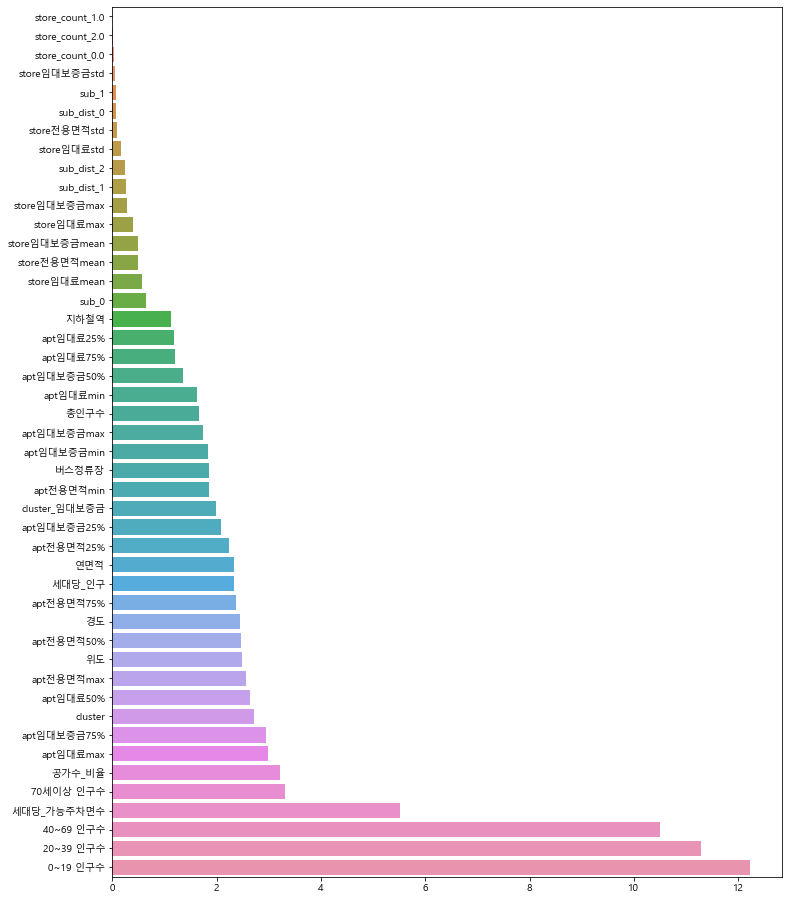

In [20]:
plt.figure(figsize=(12,16))
sns.barplot(y = X_train.columns[np.argsort(cb.feature_importances_)], x = list(cb.feature_importances_[np.argsort(cb.feature_importances_)]))

In [21]:
real_x = test_one.drop('단지코드',axis=1)
real_y = cb.predict(real_x)

In [22]:
def myfunc():
    cb = pd.read_csv("0713_cb.csv")
    cb = cb.loc[-cb['code'].isin(['C2675', 'C2335', 'C1327']),:].reset_index(drop=True)
    return cb

res = myfunc()
mae(real_y,res['num'])

59.35766962326071